Introduction to GPU Programming Summer School
========================

D. Quigley, University of Warwick

---

# Tutorial 1: GPU Libraries

The computationally intensive part of many scientific codes reduces to standard numerical operations, e.g. manipulation of large matrices/vectors, performing Fourier transforms, dealing with sparse linear algebra etc.

In the traditional High Performance Computing (HPC) realm of compiled C/C++/Fortran code, there exists a suite of standard optimised libraries for such things. The CUDA toolkit provides GPU-enabled versions of these, and [CuPy](https://docs.cupy.dev) provides a NumPy-like interface to thoes CUDA toolkit libraries.

The advantage of this approach is that no real knowledge of GPU programming is required, we simply replace calls to standard CPU functions with GPU-accelerated equivalents. The disadvantage is that we only accelerate part of the code, and may suffer performance overheads associated with transering data between host and device when we reach parts of the code which can't run on the GPU. We'll explore this penalty below.

---


## cuBLAS

BLAS is the suite of [Basic Linear Algebra Subprograms](http://www.netlib.org/blas/). These come in three levels, for both real and complex data types. 

**Level 1** : Vector-vector operations 

**Level 2** : Matrix-vector operations

**Level 3** : Matrix-matrix operations

On any well-managed HPC system, the local installations of numpy and scipy packages will be built on top of BLAS routines (written in C or Fortran) that have been optimised for the particular hardware in use. Optimised BLAS implementations for CPUs include [OpenBLAS](https://www.openblas.net/), [Atlas](http://math-atlas.sourceforge.net/), [Intel MKL](https://software.intel.com/en-us/mkl) and [AMD AOCL](https://developer.amd.com/amd-aocl/).

The CUDA toolkit includes [cuBLAS](https://developer.nvidia.com/cublas), a GPU-accelerated BLAS implementation. Let's compare how this performs in comparison to numpy. If you're interested, the numpy implementation on the SCRTP desktops has been built using OpenBLAS, but optimised only for the most common Intel CPU features to ensure compatibility. CPU performace will not be great.

We'll be using [CuPy](https://docs.cupy.dev) which provides NumPy-like interfaces to CuBLAS and other Nvidia libraries. 

[CuPy Linear Algebra documentation](https://docs.cupy.dev/en/stable/reference/linalg.html)

Let's illustrate this with a simple matrix-matrix multiplication example. The BLAS routine `dgemm` (double precision, general matrix-matrix multiply) performs the following operation.

$$ C = \alpha AB + \beta C $$

where $A$, $B$ and $C$ are matrices and $\alpha$ and $\beta$ are scalars. Other specialised routines are available for matrices with particular structure (e.g. banded, tri-diagonal, symmetric) but we won't worry about that today. In CuPy this BLAS routine is called transparently when we perform a matrix-matrix multiply.

First let's perform an operation using standard NumPy code on the CPU for reference.

In [1]:
import numpy as np     # NumPy
import cupy  as cp     # Python interface to cuBLAS and more

# Set size of matrix to work with
size = 3

# Create some square matrices and fill them with random numbers
A = np.random.rand(size, size)
B = np.random.rand(size, size)

# Alpha (we'll leave beta as zero)
alpha = 0.5

# Perform the operation described above using standard numpy and store as C_np
C_np = alpha * np.matmul(A, B) 

To make sure we're working with the same random data when performing the calculation on the GPU, we'll copy the arrays A and B from host RAM into the GPU device memory. We can then perform the multiplication on the GPU using CuPy, and copy the result back for comparison.

In [2]:
A_d = cp.asarray(A)   # Create A_d as a copy of A in device memory.
B_d = cp.asarray(B)   # Do the same for B

C_d = alpha*cp.matmul(A_d, B_d)   # Perform the multiplication and store resul tin C_d

C = cp.asnumpy(C_d)               # Copy the result C_d back to C in host RAM

If we didn't want to make sure the both computations were using the same random data then we could have created the random arrays A_d and B_d directly on the device using `cp.random.rand(size, size)`.

Let's be proper programmers and check that both computations gave the same result.

In [3]:
comp = abs(C - C_np)
if  (comp > np.finfo(float).eps).any() : 
    print("Results do not match!")
else:
    print("Results match!")

Results match!


The next thing to investigate is whether using CuPy on the GPU is any faster than using NumPy on the host CPU. Let's try a more substantial matrix and time how long numpy takes to perform the same operation as above.

In [4]:
from timeit import default_timer as timer  # Timer

size = 1000

# Create some square matrices and fill them with random numbers
A = np.random.rand(size,size)
B = np.random.rand(size,size)

# What is the time before we start the operation?
t1 = timer()

# Perform the operation described above using standard numpy
C_np = alpha * np.matmul(A,B) 

# What is the time after we finish the operation in milliseconds?
t2 = timer()

# Print time taken
print("Matrix multiplication using NumPy (host CPU) took : ",1000*(t2-t1)," milliseconds.")

Matrix multiplication using NumPy (host CPU) took :  14.432462994591333  milliseconds.


To time how long cuBLAS takes to do the same thing we'll use its own timer function.

In [5]:
# First event before we call gemm
t1 = timer()

# Do the multiplication
A_d = cp.asarray(A)             # Copy A to device
B_d = cp.asarray(B)             # Copy B to device
C_d = alpha*cp.matmul(A_d, B_d) # Perform the multiplication 
C   = cp.asnumpy(C_d)           # Copy the result back to host RAM 

# Second event after we call gemm
t2 = timer()

# Print time taken
print("Matrix multiplication using cuBLAS took : ",1000*(t2-t1)," milliseconds.")

Matrix multiplication using cuBLAS took :  17.931242007762194  milliseconds.


When I did this using the K20c in brigitte.csc.warwick.ac.uk the GPU was only slightly faster for 1000x1000 matrices. We'll explore how this speedup varies with matrix size using the GPUs in cluster a little later - timings measured inside Jupyter notebooks tend not to be reliable.

The above test might not be representitive of a real GPU-accelerated Python script. A lot of the time measured may be taken up by copying the data to and from the GPU, which will be slow compared to working with data which already exists on the GPU. 

Instead, lets create the random arrays directly on the GPU and time that seperately from the multiplication.

In [6]:
t1 = timer()

# Create new device arrays 
d_A = cp.random.rand(size,size)
d_B = cp.random.rand(size,size)

t2 = timer()

# Print time taken
print("Creating device arrays took : ",1000*(t2-t1)," milliseconds.")

Creating device arrays took :  26.376282999990508  milliseconds.


Now time just the multiplication of these arrays on the GPU device.

In [7]:
t1 = timer()

C_d = alpha*cp.matmul(A_d, B_d) # Perform the multiplication 

t2 = timer()

# Print time taken
print("Matrix multiplication on device took : ",1000*(t2-t1)," milliseconds.")

Matrix multiplication on device took :  0.7159020024118945  milliseconds.


Don't read too much into these timings - these can be quite unreliable when running inside Jupyter notebooks, however it will probably be clear that most of the time taken in our original test was the copying of data. If we work entirely on the GPU then things are much faster.

If we must copy data from the host, then best performance will be acheived by doing as much work as possible on the arrays while they are on the device, minimising copies between host and device memory.

## cuBLAS exercises

You should now have everything you need to cannibalise the code snippets above and construct some python scripts which you can run outside of this notebook environment on the HPC GPU nodes. **Please do not run matrices larger than 1000x1000 in this notebook**. On the HPC nodes you should take timings at several matrix sizes as an average over 10 or so runs.

Questions to explore:

* How large a matrix is needed before the multiplication is 10x faster on the GPU compared to numpy code? 
* What is the largest speedup you can obtain?
* How does the speedup from BLAS level 1 and 2 routines compare to BLAS level 3?
* What is the variability in your timings, what gives rise to this?
* (Advanced) Is the numpy code making use of multiple CPU cores on the HPC node?
* (Advanced) How does the cuBLAS/numpy performance compare to using scipy.linalg.blas.dgemm?
* (Advanced) How does performance change if using single rather than double precision?
* (Very Advanced) How does the shape of the matrix change performance. Why?

Tutors will be available during the session to help you answer these questions.

---

## cuFFT

cuFFT provides GPU-enabled functions to perform the Fast Fourier Transform on 1D, 2D and 3D data. It can be used as a drop-in replacement for (e.g.) numpy.fft routines.

Again we'll be using [CuPy](https://docs.cupy.dev) which provides NumPy-like interfaces to CuFFT. We will not need to call cuFFT directly.

[CuPy Fourier Transform documentation](https://docs.cupy.dev/en/stable/reference/fft.html)

To illustrate how it can be used, we'll look at a trivial image processing example. Let's say we need to obscure the identity of a porg (for GDPR reasons) by blurring an image. We can apply a blur filter by convoluting the image with a 2D Gaussian function.

A convolution can be performed with the following steps:

1. Fourier transform the image and the Gaussian.
2. Multiply each element in the Fourier-transformed image by the corresponding element in the Fourier transformed Gaussian.
3. Inverse Fourier transform the result.

i.e. a convolution becomes a multiplication in Fourier space. This is illustrated using numpy functions and the Python Image Library (PIL) below.

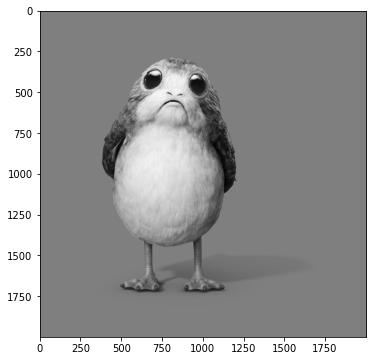

In [8]:
from PIL import Image    # Import the Python Image Library

# We want to use matplot lib to show images inline
import matplotlib.pyplot as plt
%matplotlib inline

# Open an image file and convert to single colour (greyscale)
img = Image.open('porg.jpg').convert('L')

# For now we'll work with a resized version of this image
dim = 2000
img_resized = img.resize((dim,dim))

# ... and convert it into a numpy array of floats
img_data = np.asarray(img_resized,dtype=float)

# Show the porg
plt.figure(figsize = [6, 6])
plt.imshow(img_data,cmap='gray');

Image taken from https://people.com/movies/star-wars-porgs/ (Ed Miller/2017 LucasFilm Ltd).


In [9]:
# We want to convolve this image with a Gaussian, so we need a 2D numpy array 
# representing a Gaussian function with some blurring width
width =  0.2 

# Define a Gaussian in 1D on a grid with the same number of points as the image
domain = np.linspace(-5,5,dim)
gauss = np.exp(-0.5*domain**2/(width*width)) 
    
# Roll this around the 1D boundary so that the Gaussian is centered on grid 0,0
shift = int(dim/2)
gauss = np.roll(gauss,shift)

# Turn into a 2D Gaussian
gauss2D = gauss[:,np.newaxis] * gauss[np.newaxis,:]

First let's do the convolution on the CPU using standard numpy functions so we have something to compare against.

In [10]:
# Fourier transform the image and the Gaussian using standard numpy functions
tot_t = 0.0
t1 = timer()

# Note that for NumPy we call fft2 for any type of 2D input data, real or complex.
img_fft   = np.fft.fft2(img_data)
gauss_fft = np.fft.fft2(gauss2D)

t2 = timer()

# Print time taken
f_fft_t = (t2-t1)
print("Forward fast Fourier Transforms took : ",1000*f_fft_t," milliseconds.")

Forward fast Fourier Transforms took :  282.01117100252304  milliseconds.


We now need to multiple each element in img_fft by the corresponding element in gauss_fft.

In [11]:
# Multiplication in Fourier space - note multiply not matmul
t1 = timer()

# Multiply corresponding elements together
img_conv = np.multiply(img_fft, gauss_fft)

t2 = timer()
mult_t = t2 - t1 
print("Multiplication took : ",1000*mult_t," milliseconds.")

Multiplication took :  27.800317999208346  milliseconds.


Transform the result back to real space.

In [12]:
# Transform the result back into real space using the inverse transform
t1 = timer()

img_ifft = np.fft.ifft2(img_conv)

t2 = timer()

# Print time taken
i_fft_t = t2 - t1 
print("Inverse fast Fourier Transform took    : ",1000*(t2-t1)," milliseconds.")

tot_t = f_fft_t + mult_t + i_fft_t
print("Total time taken for convolution (CPU) : ",1000*tot_t," milliseconds.")

Inverse fast Fourier Transform took    :  148.15485301369336  milliseconds.
Total time taken for convolution (CPU) :  457.96634201542474  milliseconds.


The result of the convolution should now be stored in img_ifft.

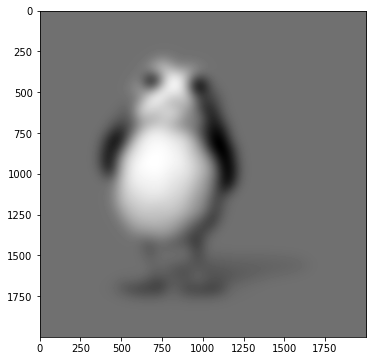

In [13]:
# Display the result of "blurring the porg"
plt.figure(figsize = [6, 6])
plt.imshow(img_ifft.real,cmap='gray');

Now let's do the same operation using the cuFFT library via pyculib. 

In [14]:
# NumPy FFT routes are agnostic to whether we pass in real or complex data. However in CuPy we 
# need to call different functions for each. To keep things as generic as possible we'll work
# with complex data by adding a zero imaginary part to our image and Gaussian arrays. 
img_data_complex = img_data + 1j * np.zeros((dim,dim))
gauss2D_complex  = gauss2D  + 1j * np.zeros((dim,dim))

This is a situation where we _must_ copy the data to the device. The GPU device cannot read data from file. We have to copy the data read by the host CPU code above onto the GPU before we can use it there.

In [15]:
t1 = timer()

# Copy the two input arrays to equivalent arrays on the device
img_data_d = cp.asarray(img_data_complex)
gauss2D_d  = cp.asarray(gauss2D_complex)

# Use CuPy fft2 function to Fourier Transform these 
img_fft_d   = cp.fft.fft2(img_data_d)
gauss_fft_d = cp.fft.fft2(gauss2D_d)

# Copy the result back to NumPy arrays on the host
img_fft = cp.asnumpy(img_fft_d)
gaus_fft = cp.asnumpy(gauss_fft_d)

t2 = timer()

# Print time taken
d_f_fft_t = t2 - t1
print("Forward fast Fourier Transforms using cuFFT took : ",1000*d_f_fft_t," milliseconds.")

Forward fast Fourier Transforms using cuFFT took :  197.52371600770857  milliseconds.


This is likely faster than on the CPU even though we incur the penalty of copying input data from host to device, and then the output from device to host.

In [16]:
# Multiplication in Fourier space on the CPU
t1 = timer()

# Multiply corresponding elements together
img_conv = np.multiply(img_fft, gauss_fft)

t2 = timer()
mult_t = t2-t1 
print("Multiplication took : ",1000*mult_t," milliseconds.")

Multiplication took :  45.872101007262245  milliseconds.


In [17]:
# Transform back into real space

t1 = timer()

# Copy img_conv to device
img_conv_d = cp.asarray(img_conv)

# inverse Fourier transform on the device
img_ifft_d = cp.fft.ifft2(img_conv_d)

# Copy output back to host
img_ifft = cp.asnumpy(img_ifft_d)

t2 = timer()

d_i_fft_t = t2 - t1
print("Inverse fast Fourier Transform using cuFFT took : ",1000*d_i_fft_t ," milliseconds.")

tot_t = d_f_fft_t + mult_t + d_i_fft_t
print("Total time taken for convolution (GPU)          : ",1000*tot_t," milliseconds.")

Inverse fast Fourier Transform using cuFFT took :  51.19027500040829  milliseconds.
Total time taken for convolution (GPU)          :  294.5860920153791  milliseconds.


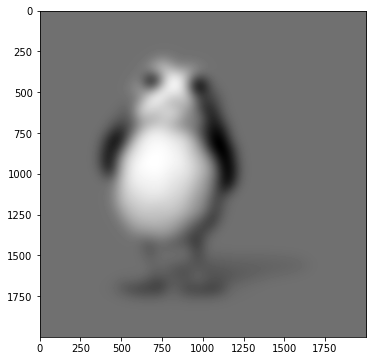

In [18]:
# Display the result of "blurring the porg" using the GPU
plt.figure(figsize = [6, 6])
plt.imshow(img_ifft.real,cmap='gray');

This probably already demonstrates a speedup, but we can do much better. We can do a lot more on the CPU than just call routines which implement Fourier Transforms and matrix-matrix multiplies. 

If we could perform the Fourier space multiplication of the two arrays on the GPU then we'd avoid having to copy them back to the host first, and also the copy of the result back to the device to be inverse transformed. Tomorrow we'll learn how to do exactly that by writing our own _kernels_. However CuPy also contains functionality which allows us to do this easily. We can call `cp.multiply(img_fft_d, gauss_fft_d)` directly on the device arrays.

In [21]:
# Start the timer
t1 = timer()

# Copy the two input arrays to equivalent arrays on the device
img_data_d = cp.asarray(img_data_complex)
gauss2D_d  = cp.asarray(gauss2D_complex)

# Use CuPy fft2 function to Fourier Transform these 
img_fft_d   = cp.fft.fft2(img_data_d)
gauss_fft_d = cp.fft.fft2(gauss2D_d)

# Now use cp.multiply to perform multiplication in Fourier space
img_conv_d = cp.multiply(img_fft_d, gauss_fft_d)

# inverse Fourier transform on the device
img_ifft_d = cp.fft.ifft2(img_conv_d)

# Copy output back to host so we can plot it
img_ifft = cp.asnumpy(img_ifft_d)

t2 = timer()

# Print time taken
print("Total time taken for convolution (GPU) : ",1000*(t2-t1)," milliseconds.")

Total time taken for convolution (GPU) :  70.14083200192545  milliseconds.


You should see that this is now _much_ faster than using the CPU. Possibly close to a factor of 10. A big chunk of the time taken previously was in copying the data between host and device, which we've now reduced significantly by doing all operations on the device. 

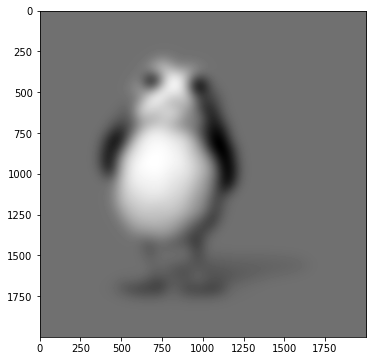

In [22]:
# Check that we still goet the correct result
plt.figure(figsize = [6, 6])
plt.imshow(img_ifft.real,cmap='gray');

## cuFFT exercises

As with the matrix exercises, you  now have everything you need to cannibalise the code snippets above and construct some python scripts which you can run outside of this notebook environment on the Tinis GPU node. As before, you should average over several runs to evaluate performance.

Things to investigate:

* How does the performance of the CuFFT compare to NumPy as a function of image size? Try using the full 2000x2000 pixel image without resizing.

* (Advanced) Investigate the [Python interface to FFTW](https://github.com/pyFFTW/pyFFTW). How does this perform in comparison to NumPy and cuFFT?  Does the GPU only appear fast here because the NumPy FFT implementation is sub-optimal? You might need to install pyFFTW using `pip install --user pyfftw` inside the environment you launched the notebook from.

* (Advanced) As with the matrix example, how does performance change if using single precision arithmetic?

* (Very advanced) Can you GPU accelerate applying a Gaussian filter to the original *colour* image by constructing a batch of FFTS, one for each colour? You might need the [cuFFT documentaion](https://docs.nvidia.com/cuda/cufft/index.html) as well as that for the Python interface.

Tutors will be available during the session to help you answer these questions.


## Other libraries

Other Nvidia GPU accelerated libraries exist which can be called via CuPy. For example...

* [cuRAND](https://docs.cupy.dev/en/stable/reference/random.html)   : Part of the Nvidia toolkit. Fast random number generation on GPUs for applications which need large numbers of samples 
* [cuDNN](https://developer.nvidia.com/cudnn)         : Nvidia Deep Neural Network Library (used by e.g. [TensorFlow](https://www.tensorflow.org/)) 

There are also many 3rd-party and open source libraries which might be useful to your research, some of which are available via environment modules on the SCRTP computers.